To make optimization of reduced models tractable, it was important to evaluate the feasibility of optimizing with established model implementations. Feasability was not universally established and it was easier to re-implement several models. Examples are given below.

In [1]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys
import pickle
#!nrnivmodl
import sciunit
import numpy as np

import matplotlib.pyplot as plt
from bluepyopt.ephys.models import ReducedCellModel
import numpy
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
from neuronunit.optimisation.optimization_management import test_all_objective_test,inject_and_plot_model
from neuronunit.optimisation.optimization_management import check_binary_match, three_step_protocol,inject_and_plot_passive_model
from neuronunit.optimisation.optimization_management import inject_and_plot_passive_model
from neuronunit.optimisation.optimization_management import inject_and_plot_model
from neuronunit.optimisation.optimization_management import test_all_objective_test,inject_and_plot_model
import plotnine
from utils import NUFeature
from sciunit.scores import ZScore
from utils import dask_map_function
from neuronunit.tests.fi import RheobaseTestP

#'bhh_dynamics.BHHBackend'
#'jNeuroML.jNeuroMLBackend',
#'neuron.NEURONBackend',


#vm,plt,dtc = inject_and_plot_model(dtc,plotly=False)

tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests

#rp = RheobaseTestP(observation = nu_tests[0].observation)
##rheobase = rp.generate_prediction(simple_cell)
#print(dtc.rheobase)

/home/user/anaconda3/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


Below I have implemented a python integrator for the Adaptive Exponential Integrate and fire model. This solver lead to faster evaluations of current injection experiments. The integrator I developed had a ```>0mV``` spiked when evaluated at default parameter values.

This is in contrast to the brian2/neuraldynamics AdExp model, which took between 2 or 3 times longer to find a rheobase current injection value [2*total,3*total].


Before JIT compilation: Time taken to find Rheobase 7.0 seconds.
After JIT compilation: 4.0


Brian2 Time taken to find Rheobase: 4.40
Brian2 Time taken to find Rheobase (parallel): 3.976


The evaluation times between Brian2 JIT and the custom written integrator are similar. Both have average runs of 4 seconds, however the spike shapes coming from the custom written code look more realistic under default parameters

time taken on block 4.080894947052002 
time taken on block 4.725911855697632 


<Figure size 432x288 with 0 Axes>

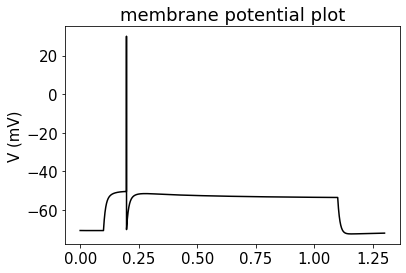

time taken on block 3.8262627124786377 
{'value': array(559.05349794) * pA} 558.43505859375 pA


In [23]:
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS["ADEXP"],backend="ADEXP")  
simple_cell.backend = "ADEXP"
model = simple_cell

model.attrs = {k:np.mean(v) for k,v in model.params.items() }

tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests

dtc = model.model_to_dtc()
dtc.attrs = model.attrs
dtc.attrs = model._backend.default_attrs
#print(dtc.attrs)

dtc.attrs['a']=4.0
dtc.attrs['b']=1.0805 
dtc.attrs['e_rev_E']=-60.0  
dtc.attrs['C']=60.0  

#print(MODEL_PARAMS["ADEXP"])

vm,plt,dtc = inject_and_plot_model(dtc,plotly=False)

plt.show()

rp = RheobaseTestP(observation = nu_tests[0].observation)
rheobase = rp.generate_prediction(model)
print(rheobase,dtc.rheobase)

Below is the Brian2/NeuralDynamics AdExp model.
Inorder to make the spike height greater than 0mV it was easier to do post simulation modifications to the orginal waveform, as it is a Neo Wave form object that is effectively boosted, or shifted above 0mV, it takes about 3 seconds in adition to complete the algorithm of determining rheobase and displaying results.

time taken on block 3.923464775085449 
time taken on block 6.7528088092803955

(-75, -56)
{'ADAPTATION_TIME_CONSTANT_tau_w': 100.0, 'ADAPTATION_VOLTAGE_COUPLING_a': 0.5, 'FIRING_THRESHOLD_v_spike': -30.0, 'MEMBRANE_RESISTANCE_R': 0.140625, 'MEMBRANE_TIME_SCALE_tau_m': 4.0625, 'RHEOBASE_THRESHOLD_v_rh': -40.625, 'SHARPNESS_delta_T': 1.0, 'SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b': 7.0, 'V_RESET': -57.375, 'V_REST': -105.0, 'b': 0.09, 'C': 1.0, 'peak_v': 0.034999999999999996}
time taken on block 4.437911033630371 
time taken on block 4.9163596630096436 


<Figure size 432x288 with 0 Axes>

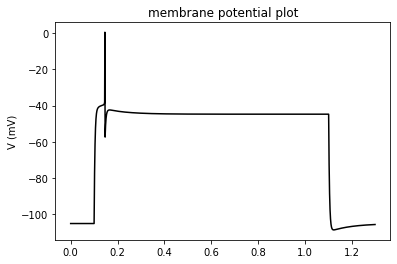

array(0.3675) * mV

In [3]:

from neuronunit.optimisation.brian_glif_model_parameters import MODEL_PARAMS as MODEL_PARAMS_depreciated
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS_depreciated["ADEXP"],backend="BADEXP")  
simple_cell.backend = "BADEXP"

model = simple_cell
model.attrs = {k:np.mean(v) for k,v in model.params.items() }
#print(model.attrs['C'])
#model.attrs['C'] = 1

#model.attrs['C'] = 0.5

dtc = model.model_to_dtc()
print(dtc.attrs)
vm,plt,dtc = inject_and_plot_model(dtc,plotly=False)
plt.show()

np.max(vm)

The next model to be evaluated is the NEURON Izhi model. The NEURON Izhi model has various draw backs. 
1. It depends on an external file which must be recompiled each time this project is recreated.
2. The build environment of NEURON is non-trivial, and only a super dedicated NEURON modeller would install it on their system. The installation time investment does not exceed the advantages of using NEURON.
3. The model implementation code is less generalizable than than the Izhi model itself
* This is likely due to a name space conflict between Capacitance.

The NEURON Izhi model took 78 seconds to reach Rheobase.

time taken on block 73.06057906150818 
time taken on block 78.1226634979248 


<Figure size 432x288 with 0 Axes>

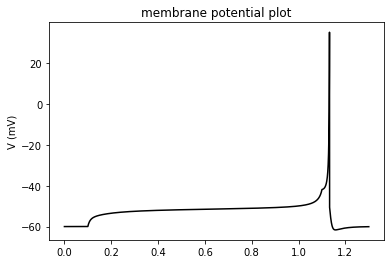

array(51.79367065) * pA

In [5]:

from neuronunit.optimisation.brian_glif_model_parameters import MODEL_PARAMS as MODEL_PARAMS_depreciated
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS_depreciated["NEURON"],backend="NEURON")  
simple_cell.backend = "NEURON"

model = simple_cell
model.attrs = {k:np.mean(v) for k,v in model.params.items() }
#print(model.attrs['C'])
dtc = model.model_to_dtc()

vm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)
plt.show()
pre_model.rheobase

# Parallel Rheobase 
Algorithm was able to speed up this slow NEURON unit code. 73/19 represents a substantial speed up. of about 3.8. This is consistent with previous work

In [6]:

tests = pickle.load(open("../metaparameters/processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests
nu_tests[0].score_type = ZScore 
rp = RheobaseTestP(observation = nu_tests[0].observation)
rheobase = rp.generate_prediction(model)


time taken on block 19.902973651885986 


In [7]:
rheobase

{'value': array(51.79317142) * pA}

Forward Euler python IZhi model is very fast. Less than a second to find rheobase, and whats more this model is just as generalizable as the original izhikitich model

125.0
time taken on block 0.3479008674621582 
time taken on block 0.7229776382446289 


<Figure size 432x288 with 0 Axes>

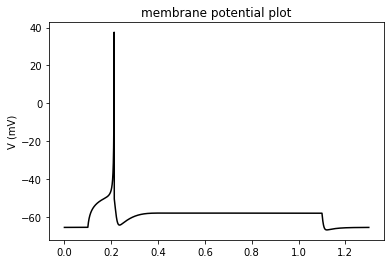

In [9]:

from neuronunit.optimisation.brian_glif_model_parameters import MODEL_PARAMS as MODEL_PARAMS_depreciated
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS["IZHI"],backend="IZHI")  
simple_cell.backend = "IZHI"

model = simple_cell
model.attrs = {k:np.mean(v) for k,v in model.params.items() }
print(model.attrs['C'])
dtc = model.model_to_dtc()


vm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)
plt.show()

In [10]:
# 'jNeuroML.jNeuroMLBackend',
#                 'neuron.NEURONBackend',

time taken on block 11.903739213943481 
time taken on block 12.13547658920288 


<Figure size 432x288 with 0 Axes>

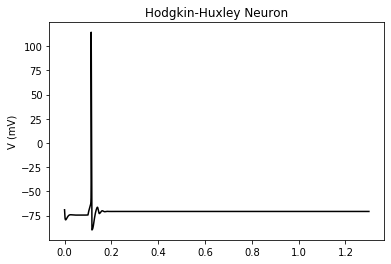

In [11]:
from neuronunit.optimisation.brian_glif_model_parameters import HH_attrs

simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=HH_attrs,backend="HH")  
simple_cell.backend = "HH"
model = simple_cell

model.attrs = {k:np.mean(v) for k,v in model.params.items() }
model.attrs['cm'] = 100.0
dtc = model.model_to_dtc()
dtc.attrs['cm'] = 100.0
dtc = model.model_to_dtc()

dtc.attrs = model.attrs 
vm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)
plt.show()

In [12]:
dtc.backend
dtc.rheobase

array(1.40762329) * pA

In [13]:
MODEL_PARAMS["NEURONHH"]
model.attrs = {k:np.mean(v) for k,v in model.params.items() }
#model.attrs

time taken on block 11.757906198501587 
time taken on block 12.154404878616333 


<Figure size 432x288 with 0 Axes>

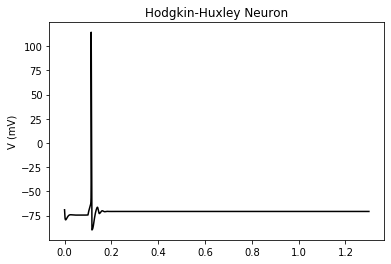

In [14]:
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=HH_attrs,backend="NEURONHH")  
simple_cell.backend = "NEURONHH"

dtc = model.model_to_dtc()
dtc.attrs = model.attrs 
model.attrs = {k:np.mean(v) for k,v in model.params.items() }

vm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)
plt.show()

In [15]:
print(dtc.rheobase)
rp = RheobaseTestP(observation = nu_tests[0].observation)
rheobase = rp.generate_prediction(model)
print(rheobase)

1.407623291015625 pA
time taken on block 10.095983266830444 
{'value': array(1.40645904) * pA}


INFO:root:time step 0 / 43
INFO:root:time step 0 / 43
INFO:root:time step 0 / 43
INFO:root:time step 0 / 43
INFO:root:time step 0 / 43
INFO:root:time step 0 / 43


time taken on block 0.03528022766113281 
time taken on block 0.29433465003967285 


<Figure size 432x288 with 0 Axes>

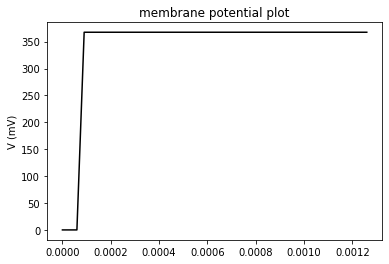

In [16]:
from neuronunit.optimisation import brian_glif_model_parameters
GLIF_RANGE = brian_glif_model_parameters.GLIF_RANGE
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=GLIF_RANGE,backend="GLIF")  
simple_cell.backend = "GLIF"
model = simple_cell

model.attrs = {k:np.mean(v) for k,v in model.params.items() }

dtc = model.model_to_dtc()
dtc.attrs = model.attrs 
vm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)
plt.show()


In [17]:
print(dtc.rheobase)
rp = RheobaseTestP(observation = nu_tests[0].observation)
rheobase = rp.generate_prediction(model)
print(rheobase)

112.5 pA


INFO:root:time step 0 / 43
INFO:root:time step 0 / 43
INFO:root:time step 0 / 43
INFO:root:time step 0 / 43


time taken on block 0.2160320281982422 
{'value': array(183.33333333) * pA}


In [18]:
dtc.rheobase

array(112.5) * pA

In [19]:
'''
from neuronunit.optimisation.brian_glif_model_parameters import HH_attrs
simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=HH_attrs,backend="GLIF")  
simple_cell.backend = "GLIF"
model = simple_cell

model.attrs = {k:np.mean(v) for k,v in model.params.items() }

dtc = model.model_to_dtc()
dtc.attrs = model.attrs 

vm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)
plt.show()
'''

'\nfrom neuronunit.optimisation.brian_glif_model_parameters import HH_attrs\nsimple_cell = ephys.models.ReducedCellModel(\n        name=\'simple_cell\',\n        params=HH_attrs,backend="GLIF")  \nsimple_cell.backend = "GLIF"\nmodel = simple_cell\n\nmodel.attrs = {k:np.mean(v) for k,v in model.params.items() }\n\ndtc = model.model_to_dtc()\ndtc.attrs = model.attrs \n\nvm,plt,pre_model = inject_and_plot_model(dtc,plotly=False)\nplt.show()\n'

INFO:root:time step 0 / 26
INFO:root:time step 0 / 26


[0.] mV [0.] mV


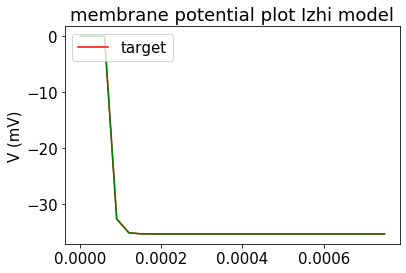

In [20]:
vm,plt = inject_and_plot_passive_model(dtc,dtc,plotly=False)
#plt.show()